This is a CNN-LSTM implementation on AMAZON's news and charts data. Two Models are trained, one with the news sentiment data (VADER_Sentiment) and one without.

In [ ]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

Data Loading and Preprocessing

In [ ]:
news_data = pd.read_csv('apple_sentiment.csv')
data_2014 = pd.read_csv('APPLE1440.csv')
data_2015 = pd.read_csv('APPLE240.csv')
data_20173 = pd.read_csv('APPLE60.csv')
data_20175 = pd.read_csv('APPLE30.csv')
data_20179 = pd.read_csv('APPLE15.csv')
data_201711 = pd.read_csv('APPLE5.csv')

# Combine the datasets
combined_data = pd.concat([data_2014, data_2015, data_20173, data_20175, data_20179, data_201711], ignore_index=True)

# Normalize numerical features in news_data
scaler = StandardScaler()
news_data[['VADER_Sentiment']] = scaler.fit_transform(news_data[['VADER_Sentiment']])

# Convert 'Date' and 'Time' columns in combined_data to a datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'] + ' ' + combined_data['Time'])
combined_data = combined_data.drop(columns=['Time']) 
scaled_data = scaler.fit_transform(combined_data[['Open', 'Close', 'High', 'Low']])

# Convert 'Date' and 'Time' columns in news_data to a datetime format
news_data['Date'] = pd.to_datetime(news_data['Date'] + ' ' + news_data['Time'])
news_data = news_data.drop(columns=['Time','Title','Contents','Social_Popularity'])  

# Merge news and charts data
merged_data = pd.merge(news_data, combined_data, on='Date', how='inner')
merged_data['VADER_Sentiment'] = merged_data['VADER_Sentiment'].apply(lambda x: 1 if int(x) == 0 else -1)
merged_data['Sentiment']= merged_data['VADER_Sentiment']
merged_data = merged_data.drop(columns=['VADER_Sentiment'])

Making a combined Data Frame of News and Charts Data

In [ ]:
df = merged_data
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,Close,High,Low,Volume,Sentiment
0,2017-12-07 20:00:00,169.47,169.68,169.34,169.62,3928,1
1,2017-12-07 20:00:00,169.47,169.63,169.34,169.47,1859,1
2,2017-12-07 20:00:00,169.47,169.63,169.44,169.62,567,1
3,2017-12-18 20:05:00,176.83,177.00,176.81,176.95,581,1
4,2017-12-21 00:00:00,174.50,176.01,174.02,175.15,43033,1
...,...,...,...,...,...,...,...
29543,2019-02-01 18:35:00,166.82,166.86,166.70,166.81,571,1
29544,2019-02-01 18:40:00,166.78,166.94,166.73,166.77,683,-1
29545,2019-02-01 19:45:00,166.17,166.24,165.90,166.13,1916,1
29546,2019-02-01 19:45:00,166.17,166.24,165.98,166.05,544,1


Creating Training Data Frame with Selected Columns

In [ ]:
train_dates = pd.to_datetime(df['Date'])

#Variables for training
cols = [
    'Open',
    'Close',
    'High', 'Low',
    'Volume',
    'Sentiment'
        ]
print(cols)


df_for_training = df[cols].astype(float)
df_for_training.index=df['Date']
df_for_training

['Open', 'Close', 'High', 'Low', 'Volume', 'Sentiment']


,Open,Close,High,Low,Volume,Sentiment
Date,,,,,,
2017-12-07 20:00:00,169.47,169.68,169.34,169.62,3928.0,1.0
2017-12-07 20:00:00,169.47,169.63,169.34,169.47,1859.0,1.0
2017-12-07 20:00:00,169.47,169.63,169.44,169.62,567.0,1.0
2017-12-18 20:05:00,176.83,177.00,176.81,176.95,581.0,1.0
2017-12-21 00:00:00,174.50,176.01,174.02,175.15,43033.0,1.0
...,...,...,...,...,...,...
2019-02-01 18:35:00,166.82,166.86,166.70,166.81,571.0,1.0
2019-02-01 18:40:00,166.78,166.94,166.73,166.77,683.0,-1.0
2019-02-01 19:45:00,166.17,166.24,165.90,166.13,1916.0,1.0


Scaling of the Open And Close Values of the Training Data Frame

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Close']])

df_for_training_scaled

array([[0.29976966, 0.29980233, 0.30060406, 0.3024198 , 0.04561452,
        1.        ],
       [0.29976966, 0.29925324, 0.30060406, 0.3007774 , 0.02158181,
        1.        ],
       [0.29976966, 0.29925324, 0.30170236, 0.3024198 , 0.00657444,
        1.        ],
       ...,
       [0.26357354, 0.26202504, 0.26282262, 0.26420672, 0.0222439 ,
        1.        ],
       [0.26357354, 0.26202504, 0.26370126, 0.26333078, 0.00630728,
        1.        ],
       [0.2617089 , 0.26125631, 0.26359143, 0.26420672, 0.0081077 ,
        1.        ]])

Creating Train Input features and Target Variables

In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    # Extract the relevant columns for the input sequence (trainX)
    X_sequence = df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]]  # Open, Close, High, Low, Volume, VADER
    trainX.append(X_sequence)

    # Extract the target values (trainY)
    y_sample = df_for_training_scaled[i + n_future - 1:i + n_future, [1, 2]]  # Open, Close
    trainY.append(y_sample)

trainX, trainY = np.array(trainX), np.array(trainY)


print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (29543, 5, 6).
TrainY shape = (29543, 1, 2).


Train data with and without Sentiment

In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_sentiment, X_test_lstm_without_sentiment, y_train_lstm_without_sentiment, y_test_lstm_without_sentiment = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_sentiment, X_test_lstm_sentiment, y_train_lstm_sentiment, y_test_lstm_sentiment = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_sentiment.shape,X_train_lstm_sentiment.shape

((23634, 5, 5), (23634, 5, 6))

Validation data with and without Sentiment

In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_sentiment, X_val_lstm_without_sentiment, y_train_lstm_without_sentiment, y_val_lstm_without_sentiment = train_test_split(X_train_lstm_without_sentiment, y_train_lstm_without_sentiment, test_size=0.1, shuffle=False)

X_train_lstm_sentiment, X_val_lstm_sentiment, y_train_lstm_sentiment, y_val_lstm_sentiment = train_test_split(X_train_lstm_sentiment, y_train_lstm_sentiment, test_size=0.1, shuffle=False)

X_train_lstm_without_sentiment.shape,X_train_lstm_sentiment.shape

((21270, 5, 5), (21270, 5, 6))

CNN-LSTM Model

In [ ]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

Training / Fitting the model with and without sentiment data

In [ ]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cnn_lstm_model_without_sentiment=build_model((X_train_lstm_without_sentiment.shape[1],X_train_lstm_without_sentiment.shape[2]))
cnn_lstm_model_sentiment=build_model((X_train_lstm_sentiment.shape[1],X_train_lstm_sentiment.shape[2]))

history_without_sentiment = cnn_lstm_model_without_sentiment.fit(X_train_lstm_without_sentiment, y_train_lstm_without_sentiment, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_sentiment, y_val_lstm_without_sentiment), verbose=1,callbacks=[early_stopping] )

history_sentiment = cnn_lstm_model_sentiment.fit(X_train_lstm_sentiment, y_train_lstm_sentiment, epochs=50, batch_size=64, validation_data=(X_val_lstm_sentiment, y_val_lstm_sentiment), verbose=1,callbacks=[early_stopping] )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 4, 128)            1408      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 2, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_8 (Bidirecti  (None, 1, 512)            657408    
 onal)                                                           
                                                      

Training loss and Validation loss without sentiment data

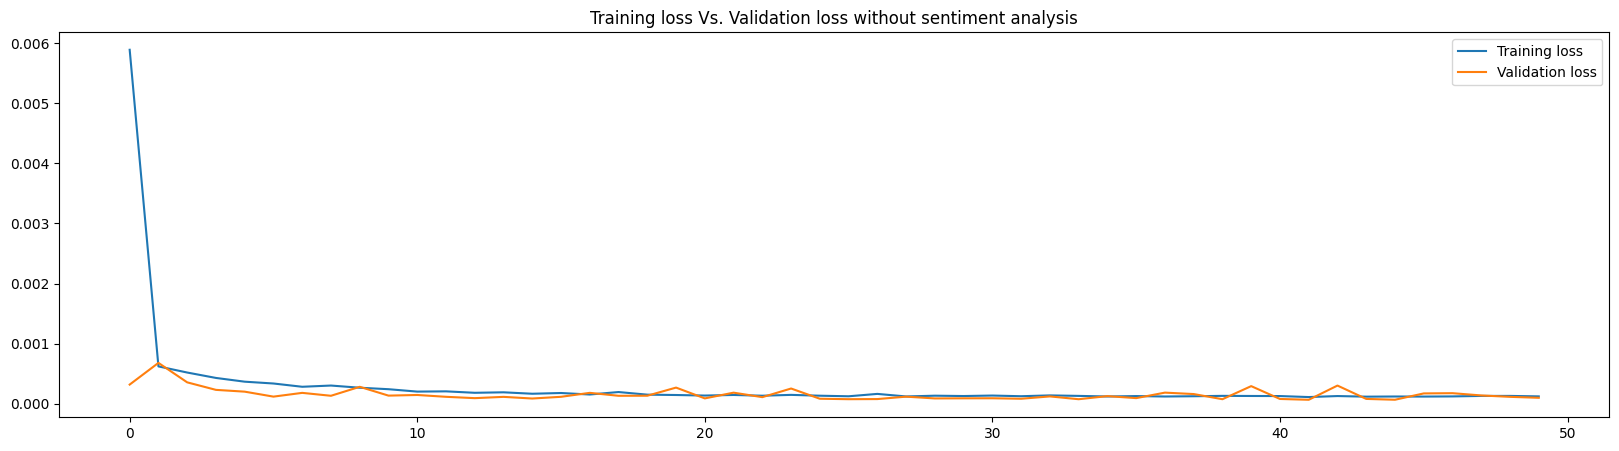

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_without_sentiment.history['loss'], label='Training loss')
plt.plot(history_without_sentiment.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without sentiment analysis')
plt.legend()

Training loss and Validation loss with sentiment data

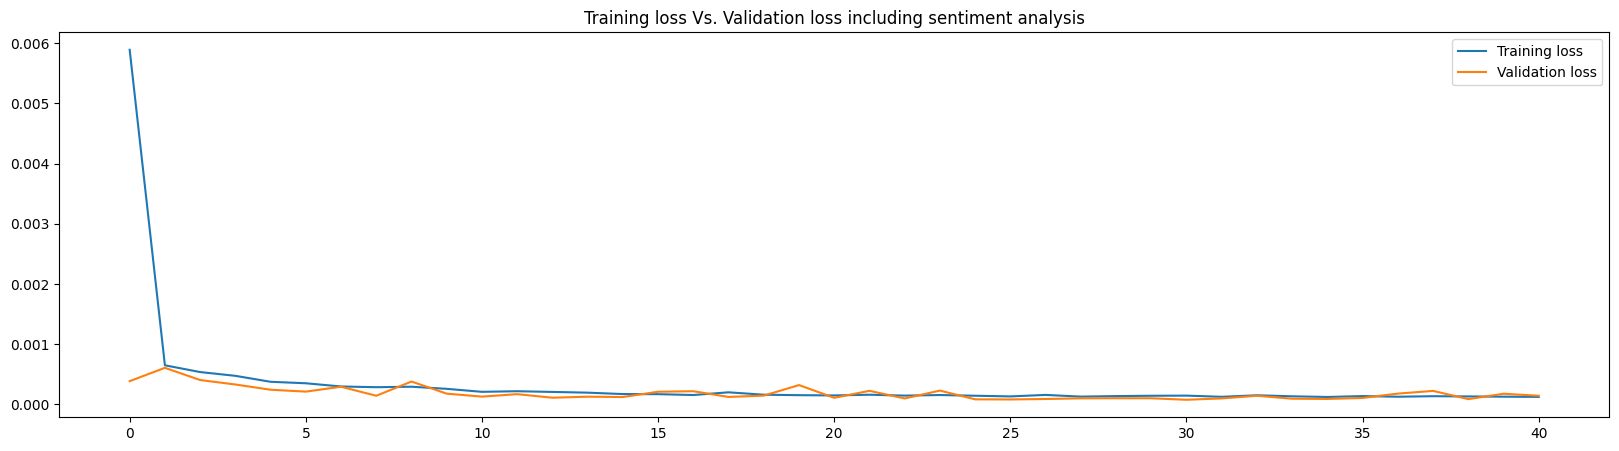

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_sentiment.history['loss'], label='Training loss')
plt.plot(history_sentiment.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including sentiment analysis')
plt.legend()

Plotting the predictions with or without sentiment data

In [81]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,sentiment,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if sentiment :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

Prediction on Train Data. The metrics for the prediction is Mean Squared Error

In [82]:
training_dates= df_for_training.index[:X_train_lstm_without_sentiment.shape[0]]
#Make prediction
training_prediction_without_sentiment = cnn_lstm_model_without_sentiment.predict(X_train_lstm_without_sentiment)

training_prediction_sentiment = cnn_lstm_model_sentiment.predict(X_train_lstm_sentiment)

training_prediction_without_sentiment=training_prediction_without_sentiment.reshape(training_prediction_without_sentiment.shape[0], training_prediction_without_sentiment.shape[2])

training_prediction_sentiment=training_prediction_sentiment.reshape(training_prediction_sentiment.shape[0], training_prediction_sentiment.shape[2])

y_train_pred_lstm_without_sentiment = scaler_for_inference.inverse_transform(training_prediction_without_sentiment)

y_train_pred_lstm_sentiment = scaler_for_inference.inverse_transform(training_prediction_sentiment)

y_train_lstm_reshaped_without_sentiment=y_train_lstm_without_sentiment.reshape(y_train_lstm_without_sentiment.shape[0], y_train_lstm_without_sentiment.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_sentiment)

665/665 [==============================] - 10s 14ms/step


Training Prediction without sentiment data

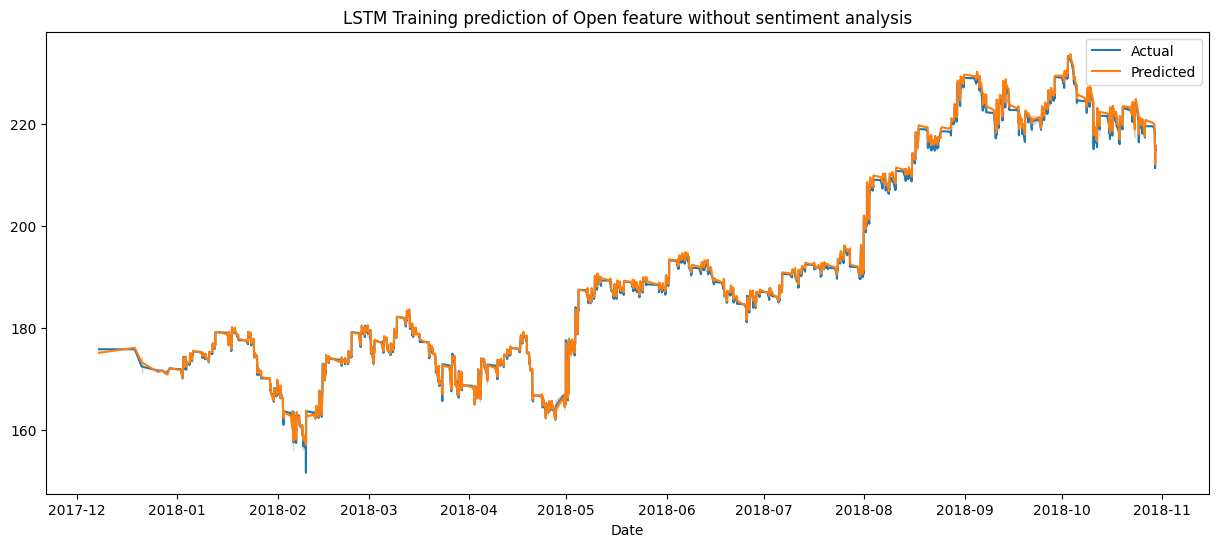

Mean square error for Open =0.3913961230647047


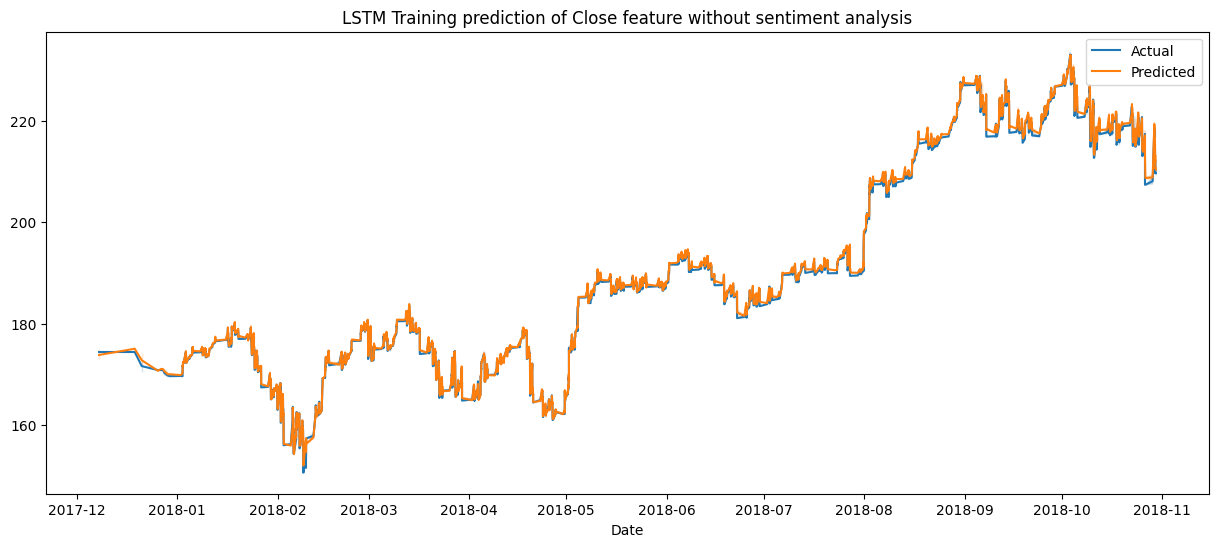

Mean square error for Close =0.41648884877030623
Total mean square error 0.40394248591750836


In [83]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_sentiment)

Training Prediction with sentiment data

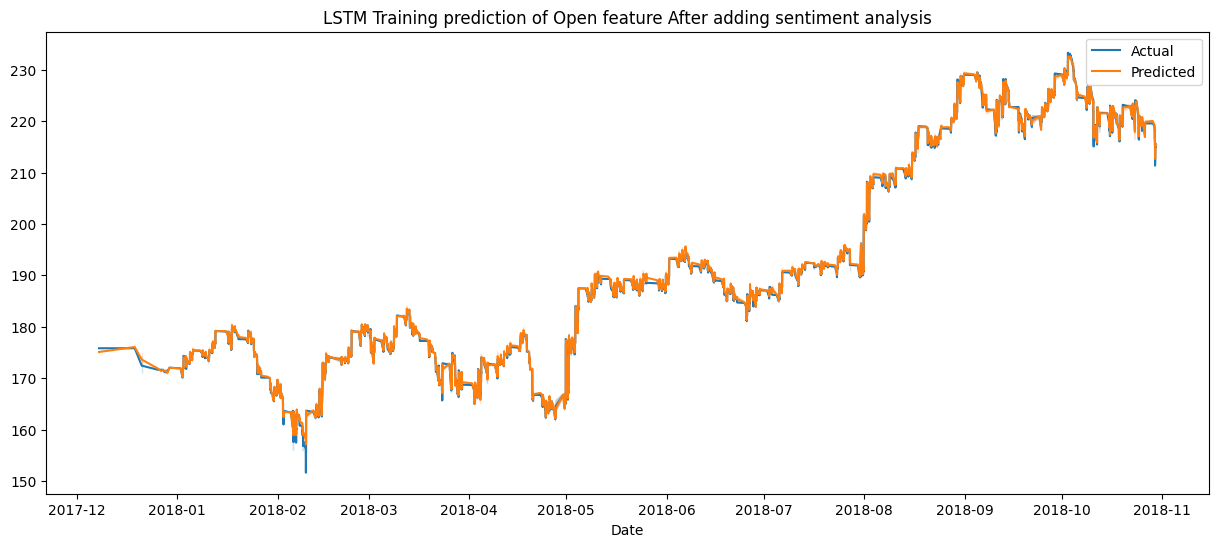

Mean square error for Open =0.32625958921826326


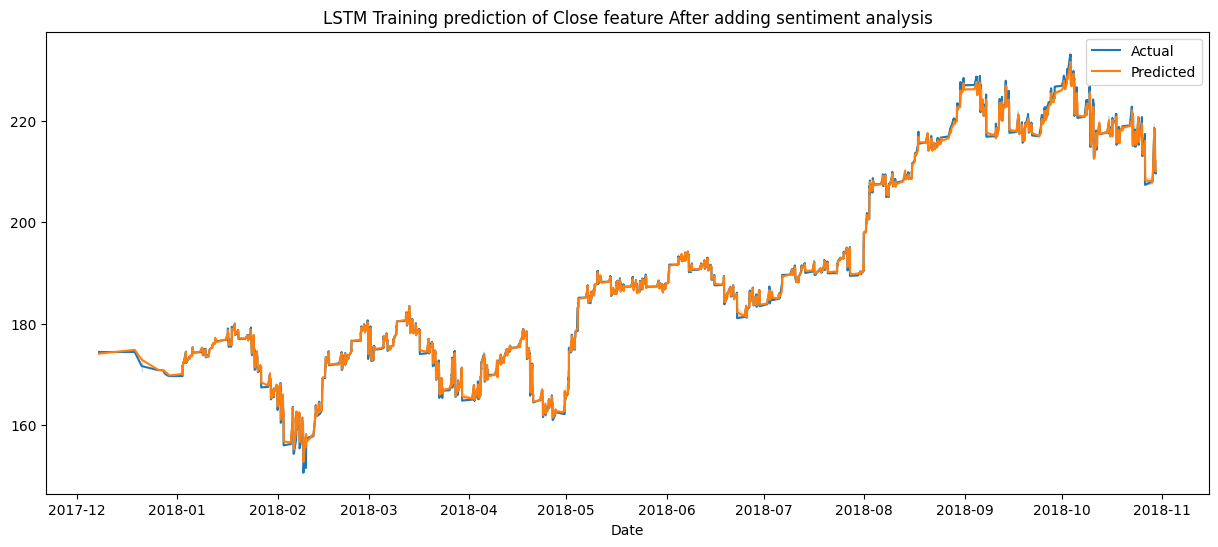

Mean square error for Close =0.3673097320058351
Total mean square error 0.34678466061205504


In [84]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_sentiment)

Prediction on Validation Data. The metrics for the prediction is Mean Squared Error

In [85]:
validation_dates= df_for_training.index[X_train_lstm_without_sentiment.shape[0]:X_train_lstm_without_sentiment.shape[0] + X_val_lstm_without_sentiment.shape[0]]
#Make prediction
validation_prediction_without_sentiment = cnn_lstm_model_without_sentiment.predict(X_val_lstm_without_sentiment)

validation_prediction_sentiment = cnn_lstm_model_sentiment.predict(X_val_lstm_sentiment)

validation_prediction_without_sentiment=validation_prediction_without_sentiment.reshape(validation_prediction_without_sentiment.shape[0], validation_prediction_without_sentiment.shape[2])


validation_prediction_sentiment=validation_prediction_sentiment.reshape(validation_prediction_sentiment.shape[0], validation_prediction_sentiment.shape[2])


y_val_pred_lstm_without_sentiment = scaler_for_inference.inverse_transform(validation_prediction_without_sentiment)
y_val_pred_lstm_sentiment = scaler_for_inference.inverse_transform(validation_prediction_sentiment)

y_val_actual_lstm_reshaped_without_sentiment=y_val_lstm_without_sentiment.reshape(y_val_lstm_without_sentiment.shape[0], y_val_lstm_without_sentiment.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_sentiment)

74/74 [==============================] - 1s 16ms/step


Validation Prediction without sentiment data

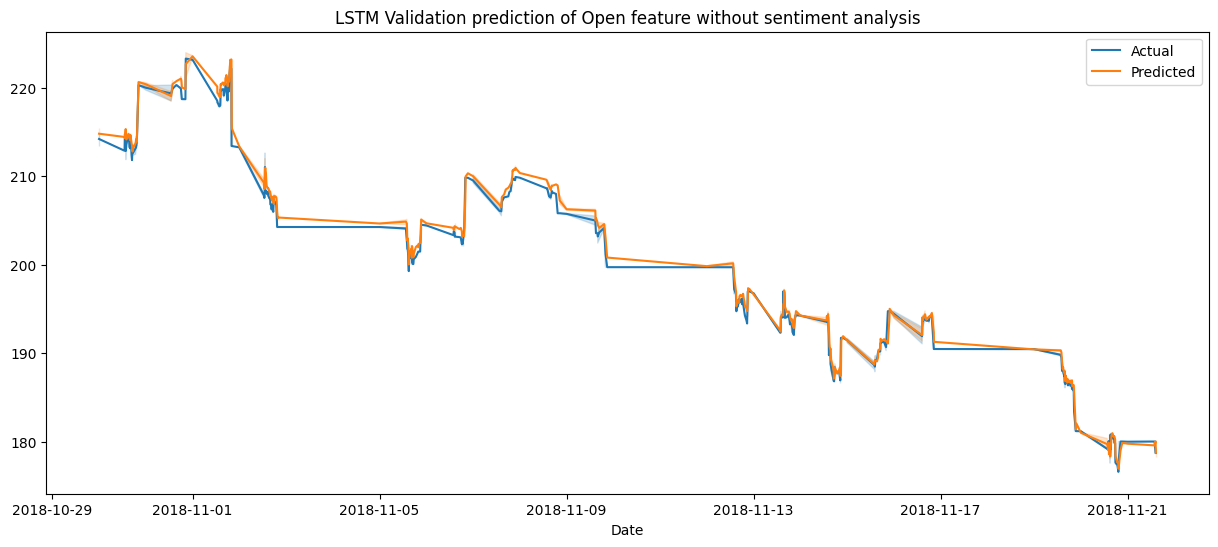

Mean square error for Open =0.5754535913531805


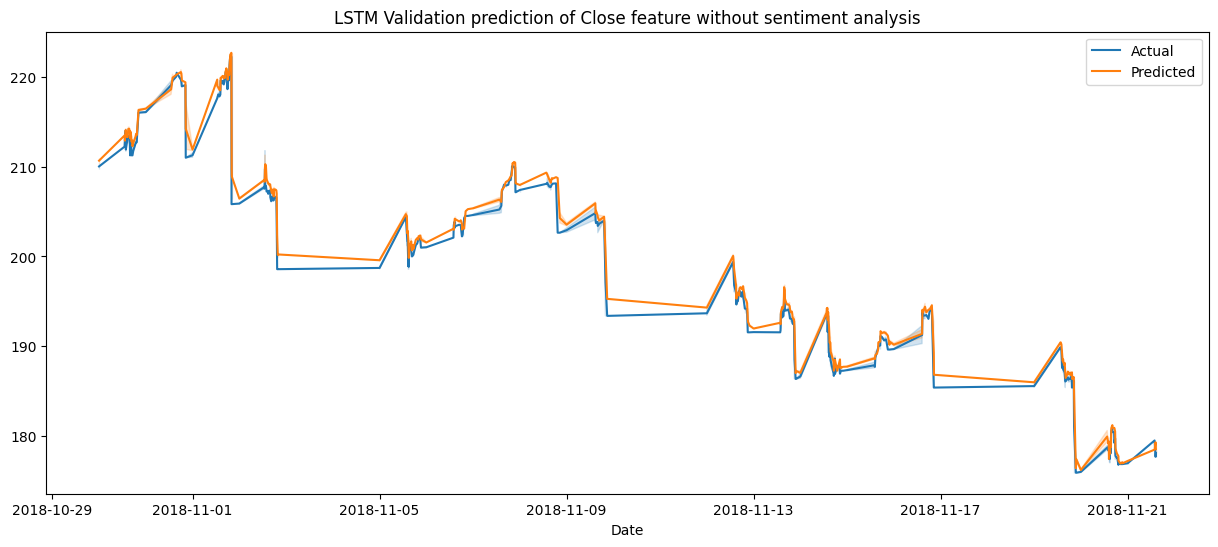

Mean square error for Close =1.0717405454831124
Total mean square error 0.8235970684181446


In [86]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_sentiment)

Validation Prediction with sentiment data

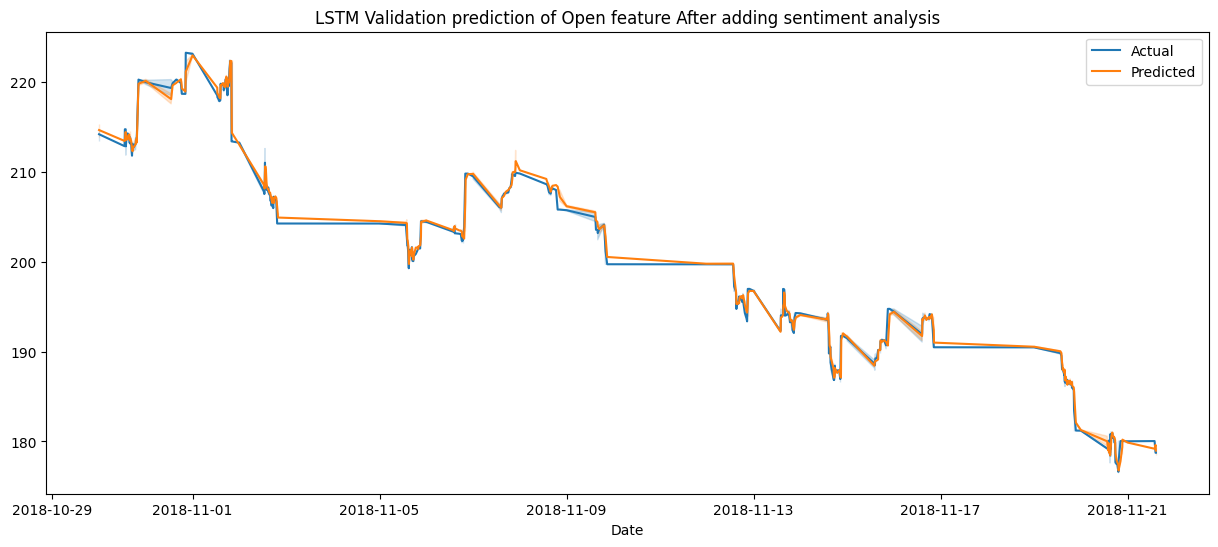

Mean square error for Open =0.47796832117727317


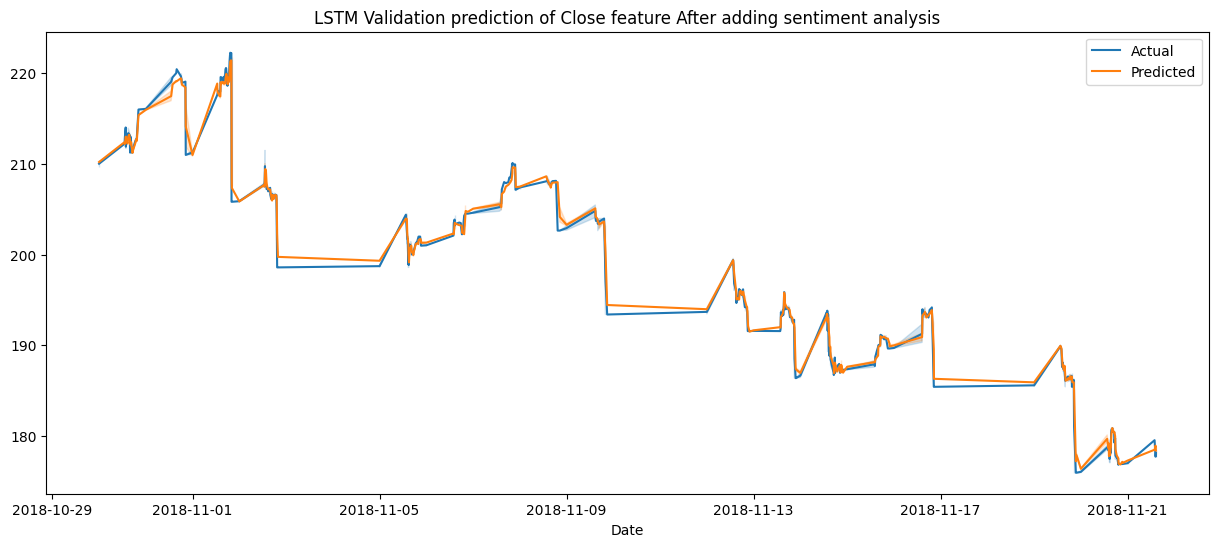

Mean square error for Close =0.8136440885197841
Total mean square error 0.6458062048485282


In [87]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_sentiment)

Prediction on Test Data. The metrics for the prediction is Mean Squared Error

In [88]:
testing_dates= df_for_training.index[-X_test_lstm_without_sentiment.shape[0]:]
#Make prediction
testing_prediction_without_sentiment = cnn_lstm_model_without_sentiment.predict(X_test_lstm_without_sentiment)
testing_prediction_sentiment = cnn_lstm_model_sentiment.predict(X_test_lstm_sentiment)

testing_prediction_without_sentiment=testing_prediction_without_sentiment.reshape(testing_prediction_without_sentiment.shape[0], testing_prediction_without_sentiment.shape[2])
testing_prediction_sentiment=testing_prediction_sentiment.reshape(testing_prediction_sentiment.shape[0], testing_prediction_sentiment.shape[2])

y_test_pred_lstm_without_sentiment = scaler_for_inference.inverse_transform(testing_prediction_without_sentiment)
y_test_pred_lstm_sentiment = scaler_for_inference.inverse_transform(testing_prediction_sentiment)

y_test_actual_lstm_reshaped_without_sentiment=y_test_lstm_without_sentiment.reshape(y_test_lstm_without_sentiment.shape[0], y_test_lstm_without_sentiment.shape[2])

y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_sentiment)

185/185 [==============================] - 3s 14ms/step


Testing Prediction without sentiment data

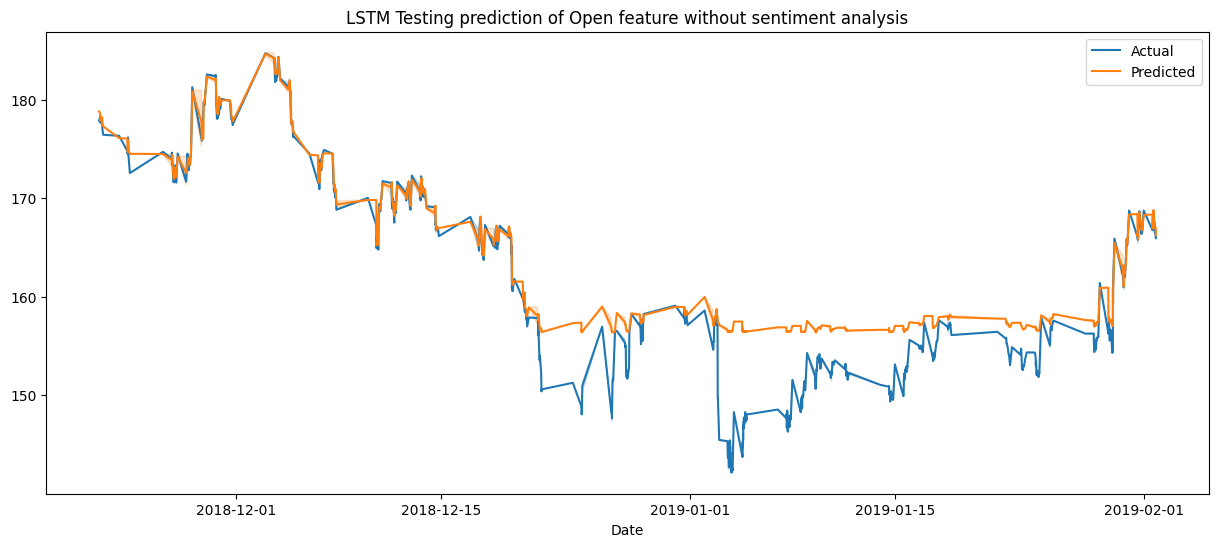

Mean square error for Open =24.849065825925145


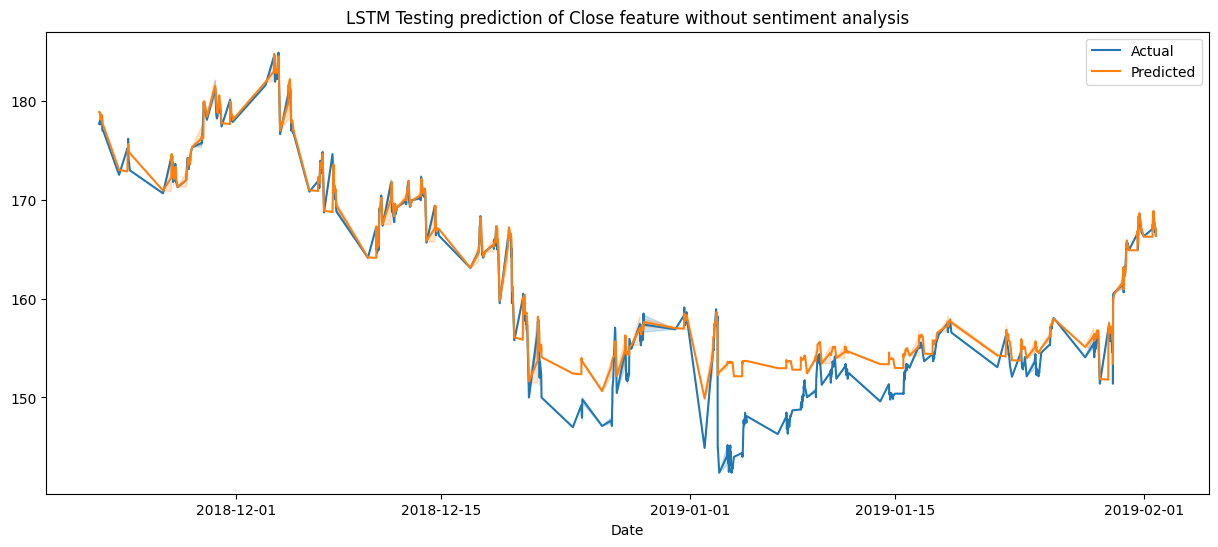

Mean square error for Close =16.638540106729774
Total mean square error 20.743802966327326


In [89]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_sentiment)

Testing Prediction with sentiment data

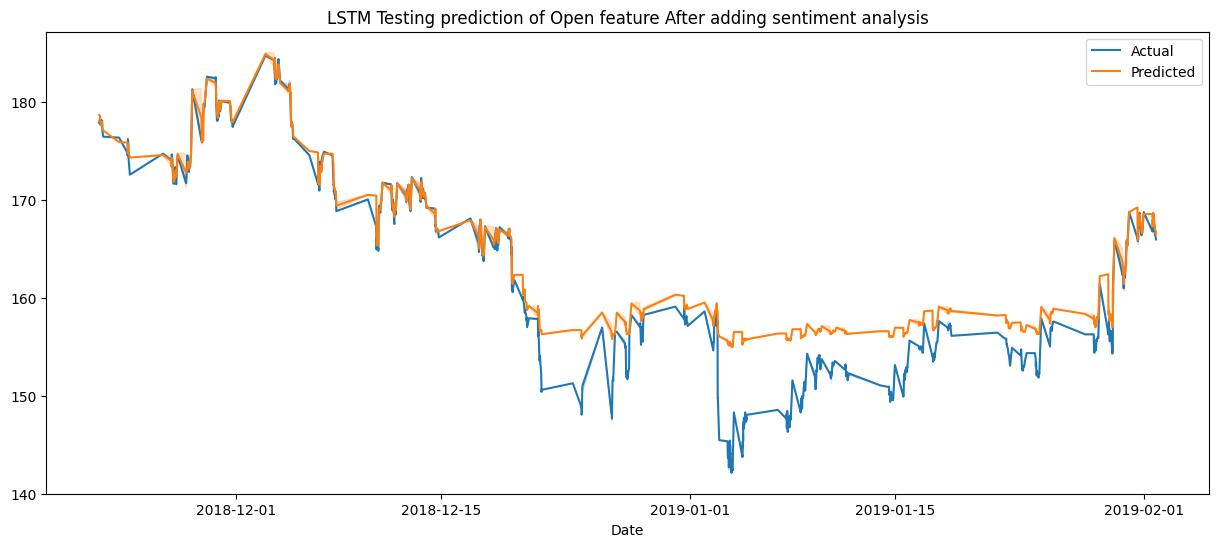

Mean square error for Open =21.123338326314567


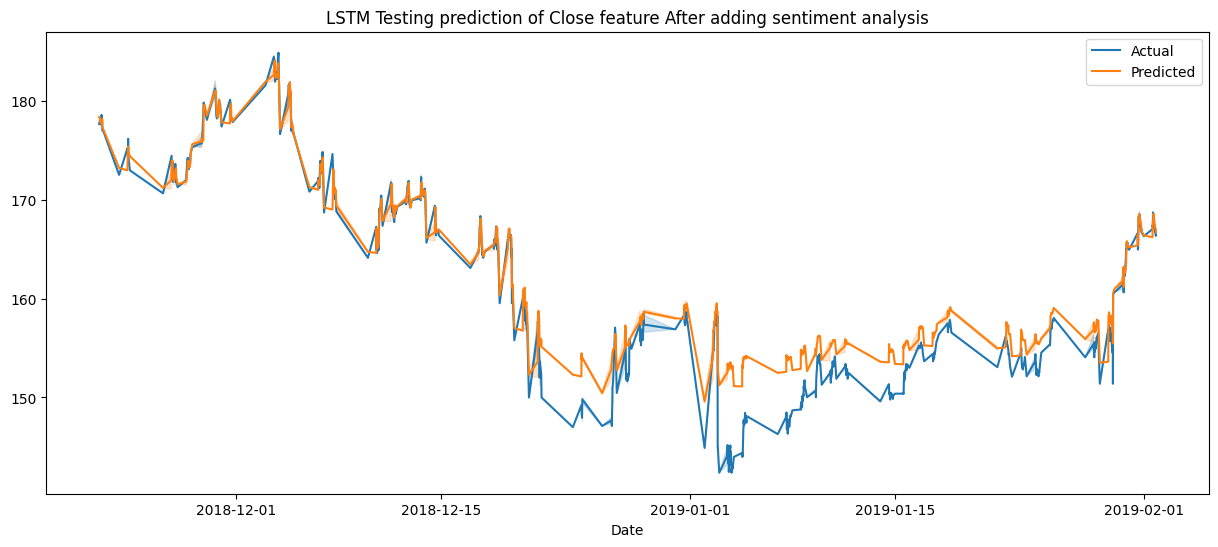

Mean square error for Close =15.072533744555553
Total mean square error 18.09793603543511


In [90]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_sentiment)